<a href="https://colab.research.google.com/github/b-hill/cop4630/blob/master/hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW 3

References: [This notebook](https://github.com/Benlau93/Machine-Learning-by-Andrew-Ng-in-Python/blob/master/LogisticRegression/ML_LogisticRegression.ipynb) greatly helped understand how to build logistic regression from scratch. Its modified a bit to be easier to understand and leasves out some parameters we dont need. 

### Imports

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Problem 1: Generating the data

### Function: get_random_data

This function generates random data. 

Config: 
*   2 features -> shape `(m,2)`
*   Binary classification -> shape `(m,1)`
*   Populates around a line `w * x + b`
*   Direction (up or down) from line determined by class label `c`. 
*   Distance from line determined by `n` which is number generated from normal distribution defined by `sigma` and `mu`. 
*   Classes: `c` <- 50/50 boolean
*   Feat. 1: `x_1` <- random uniform float [0,1)
*   Feat. 2: `x_2` <- `w * x_1 + b + (-1)**c * n`

Parameters:
*   User entered:
  *   `w`: Central line slope
  *   `b`: Central line intercept
  *   `mu`: Mean of normal distribution
  *   `sigma`: Standard deviation of normal distribution
  *   `m`: Number of data instances to generate

*   Generated: 
  *   `c`:  Class label, 50/50 boolean
  *   `n`:  `np.random.normal(mu, sigma, 1)`







In [0]:
def get_random_data(w, b, mu, sigma, m): 
  
  # init dfs
  labels = pd.DataFrame()
  data = pd.DataFrame()

  # fill dfs
  for i in range(0, m):

    # labels
    c = random.choice([0, 1])
    row = pd.Series([c], index=['c'])
    row_labels = pd.DataFrame([row])
    labels = pd.concat([row_labels, labels], ignore_index=True)

    # data
    x_1 = random.uniform(0,1)
    n = np.random.normal(mu, sigma, 1)
    x_2 = w * x_1 + b + (-1)**c * n
    row = pd.Series([x_1, x_2], index=['x_1', 'x_2'])
    row_data = pd.DataFrame([row])
    data = pd.concat([row_data, data], ignore_index=True)

  return [labels, data]

### Manipulate data generation

In [0]:
w = .6
b = .8
mu = .5
sigma = .2
m = 1000

`labels` contains the features for each row, `x_1` and `x_2`

`data` contains the class label for each row, `c`

In [0]:
labels, data = get_random_data(w, b, mu, sigma, m)

Sample of combined data

In [5]:
main = pd.concat([data, labels], axis=1, ignore_index=True).head()
main.columns = ['x_1', 'x_2', 'c']
main

,x_1,x_2,c
0,0.809306,[0.6717362215398872],1
1,0.654691,[0.5791214576885365],1
2,0.005463,[0.4323395507403677],1
3,0.711838,[0.7006649167482899],1
4,0.228140,[1.3883496799812927],0


### Function: display_random_data

2D scatter plot of generated data. 

*   Blue dots correspond to `c=0`
*   Red dots correspond to `c=1`

In [0]:
def display_random_data(labels, data):
  main = pd.concat([data, labels], axis=1, ignore_index=True)
  main.columns = ['x_1', 'x_2', 'c']
  ax = sns.scatterplot(x="x_1", y="x_2", data=main, hue="c", palette=["Blue", "Red"])
  ax.plot()

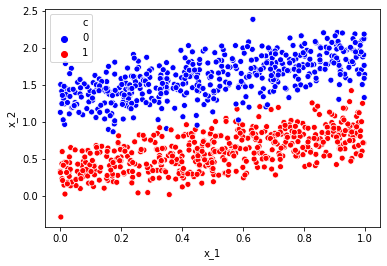

In [7]:
display_random_data(labels, data)

### Split data

80% of the data is sent to the train set which is used to fit the model. 

The other 20% of the data is sent ot the test set which is used to judge the accuracy of the model after training. 

In [0]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)

Due to server side change where the default TF version has been updated by google, these changes are needed to prevent type error bugs.

In [0]:
# side affect of tf update from 1.4 to 2.2
x_train = np.asarray(x_train).astype(np.float32)
x_test = np.asarray(x_test).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)

## Problem 2: Logistic Regression using Keras

### Model construction 

This model is very simple and consits of just 1 dense layer. 
*   The `Sequential` model is a linear stack of layers.
*   The `Dense` layer has a single dimension output and takes in the 2 features of each instance.
*   The `sgd` optimizer stands for stochastic gradient descent. 
*   The `binary_crossentropy` loss function is used for classification between 2 classes, hence binary. 
*   The `accuracy` metric returns a percentage of correct predictions. 

In [0]:
model = Sequential()
model.add(Dense(1, input_shape=(2,)))
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

### Model training

*   `epochs` determines how many iterations to train the model
*   `batch_size` determines the number of samples per gradient update. 

In [11]:
model.fit(x_train, y_train, epochs=1000, batch_size=8, verbose=1)

Epoch 1/1000
100/100 [==============================] - 0s 955us/step - loss: 0.8220 - accuracy: 0.3787
Epoch 2/1000
100/100 [==============================] - 0s 976us/step - loss: 0.3959 - accuracy: 0.9162
Epoch 3/1000
100/100 [==============================] - 0s 912us/step - loss: 0.2172 - accuracy: 0.9825
Epoch 4/1000
100/100 [==============================] - 0s 908us/step - loss: 0.1406 - accuracy: 0.9862
Epoch 5/1000
100/100 [==============================] - 0s 980us/step - loss: 0.1097 - accuracy: 0.9887
Epoch 6/1000
100/100 [==============================] - 0s 982us/step - loss: 0.0925 - accuracy: 0.9875
Epoch 7/1000
100/100 [==============================] - 0s 924us/step - loss: 0.0817 - accuracy: 0.9900
Epoch 8/1000
100/100 [==============================] - 0s 1ms/step - loss: 0.0751 - accuracy: 0.9875
Epoch 9/1000
100/100 [==============================] - 0s 930us/step - loss: 0.0698 - accuracy: 0.9875
Epoch 10/1000
100/100 [==============================] - 0s 1ms/st

### Model evaluation 

Gets the weights and bias the model generates. These will be used to generate the line the model uses to divide the data up into the 2 classes. 

This line is found by `x_2 = -(w1 * x1 + b) / w2` which is derived from `w1 * x1 + w2 * x2 + b = 0`.

In [12]:
weights, bias = model.layers[0].get_weights()
print(weights, bias)

[[ 2.4521956]
 [-3.6942034]] [3.200983]


Accuracy rating of the model. 

In [13]:
loss, acc = model.evaluate(x_test, y_test)
print(loss, acc)

7/7 [==============================] - 0s 1ms/step - loss: 0.0052 - accuracy: 1.0000
0.005185883026570082 1.0


### Function: model_accuracy

Similar to the first graph. 

*   The `blue/green` line describes the actual line used to generate the data in the first place.
*   The `orange` line describes the line the model guesses is used to generate the data. Above this line, the model would guess every point is `blue` and below this point it would guess every point is `red`. 

In [0]:
def model_accuracy(labels, data, w, b, weights, bias):
  main = pd.concat([data, labels], axis=1, ignore_index=True)
  main.columns = ['x_1', 'x_2', 'c']
  ax = sns.scatterplot(x="x_1", y="x_2", data=main, hue="c", palette=["Blue", "Red"])
  xmax =  data['x_1'].max()
  ax.plot([0, xmax], [ b, w*xmax + b], linewidth=4)
  ax.plot([0, xmax], [-1*bias[0]/weights[1], -1*((weights[0]*xmax)+bias[0])/weights[1]], linewidth=4)

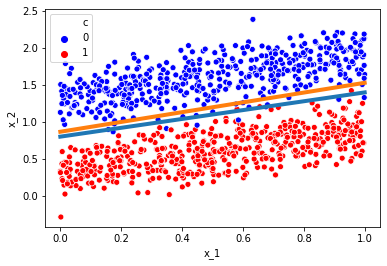

In [15]:
model_accuracy(labels, data, w, b, weights, bias)

### Class activation heatmap

This z value represents the output of the model i.e. what class it thinks any given instance is. This follows the equation described earlier, `w1 * x1 + w2 * x2 + b = z`. As you can see the confidence of the model increases as you move perpendicularly from the 

In [0]:
def heatmap(weights, bias, data):
  # mapping x and y values to data from df
  y, x = np.meshgrid(np.linspace(data['x_2'].min(), data['x_2'].max(), 100), np.linspace(data['x_1'].min(), data['x_1'].max(), 100))

  # get z value from mapped values and weights and bias
  z = bias + y * weights[1] + x * weights[0]

  # sizing 
  z = z[:-1, :-1]
  z_min, z_max = -np.abs(z).max(), np.abs(z).max()

  fig, ax = plt.subplots()
  c = ax.pcolormesh(x, y, z, cmap='RdBu_r', vmin=z_min, vmax=z_max)
  ax.set_title('Heatmap')
  ax.axis([x.min(), x.max(), y.min(), y.max()])
  fig.colorbar(c, ax=ax)

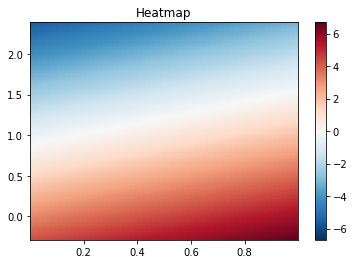

In [17]:
heatmap(weights, bias, data)

## Problem 3: Logistic Regression using numpy 

This should have roughly the same results as the keras model but built from scracth with some help from numpy.

### Function: sigmoid

This is the activation function. Activation functions take the output of the model and "correct" it to fit into one of the class labels. They are also one of the primary differences between linear regression models and logistic regression models.

In [0]:
def sigmoid(z):
    return 1/ (1 + np.exp(-z))

### Function: cost_function

Cost functions determine the error between the predicted classes and the actual classes. This is accomplished by applying the activation function to the current predictions. Comparing the resulting guesses to the actual labels and finding the gradient.

In [0]:
def cost_function(weights, X, y):
    m=len(y)
    
    predictions = sigmoid(np.dot(X,weights))
    error = (-y * np.log(predictions)) - ((1-y)*np.log(1-predictions))

    cost = 1/m * sum(error)
    grad = 1/m * np.dot(X.transpose(),(predictions - y))
    
    return cost[0] , grad

### Function: gradient_descent

This function iteratively applies the cost function to the intial weights. With every iteration, it looks at "how wrong" the weights are from the cost function adn adjusts them accordingly. If done over hundreds of iterations. The weights and bias of the model get increasingly accurate until `w1 * x2 + w2 * x2 + b = z` is very good at estimating what z will be, which represents the class label of an instance.

`learn_rate` is a modifier which can either inflate or deflate the calcualted gradient in order to increase or decrease the step sizes used to modify the weights. This value has a sweet spot. If its set high it will learn faster but be less accurate. A lower learning rate will take longer but be more accurate. 

`iters` is how many iterations to run the cost function. You could also write this function with a while loop so it will perform iterations endlessly until the error is below a threshold. In this situation the choice of learning rate is even more crucial. 

In [0]:
def gradient_descent(X,y,weights,learn_rate,iters):    
    m=len(y)
    
    for i in range(iters):
        cost, grad = cost_function(weights, X, y)
        weights = weights - (learn_rate * grad)
    
    return weights

### Model construction + training

Here i chose a learning rate of 1 and 1000 iterations to match 1000 epochs of the keras model. 

In [0]:
x_train = np.append(np.ones((x_train.shape[0],1)), x_train, axis=1)
initial_weights = np.zeros((x_train.shape[1], 1))
weights = gradient_descent(x_train,y_train,initial_weights,1,1000)
weights = weights[1:]
bias = weights[0]

### Model accuracy

This graph works the same as problem 2 but the weights and bias used to determine the class/z value are from the numpy logistic regression model rather than the keras model. 

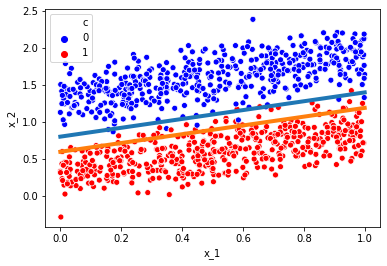

In [22]:
model_accuracy(labels, data, w, b, weights, bias)

### Class activation heatmap 

This heatmap works the same as problem 2 but the weights and bias used to determine the class/z value are from the numpy logistic regression model rather than the keras model. 

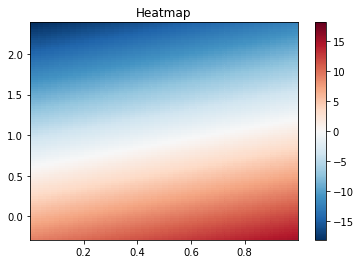

In [23]:
heatmap(weights, bias, data)